<a href="https://colab.research.google.com/github/AlkaTiwary/Final_Year_Project/blob/main/Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MOOCS DROPOUT PREDICTION USING GNN**

In [1]:
import os, sys
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 2.2.1+cu121.  CUDA version: 12.1


In [3]:

install_command1 = "pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html"
install_command2 = "pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html"

In [4]:
!{sys.executable} -m {install_command1}
!{sys.executable} -m {install_command2}

Looking in links: https://data.dgl.ai/wheels/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.5/467.5 MB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166

In [5]:
!apt-get update
!apt-get install -y --allow-downgrades libcudart11.0

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,789 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,373 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,308 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubu

In [6]:
!pip install libcublas11.0

ERROR: Could not find a version that satisfies the requirement libcublas11.0 (from versions: none)
ERROR: No matching distribution found for libcublas11.0


In [7]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
!pip install dgl
import dgl
from dgl import function as fn

In [8]:
from dgl.dataloading import DataLoader

In [9]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cpu')

**Data Loading**

In [10]:
!tar xzf data.tar.gz

tar (child): data.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [11]:
!ls

sample_data  test.csv  trainingproject.csv


In [12]:
!cat Xente_Variable_Definitions.csv

cat: Xente_Variable_Definitions.csv: No such file or directory


In [13]:
!mkdir -p models

In [14]:
df_train = pd.read_csv('trainingproject.csv')
df_train['dataset'] = 'train'
df_test = pd.read_csv('test.csv')
df_test['dataset'] = 'test'

In [15]:
df = pd.concat([df_train, df_test], axis=0)

In [16]:
df.shape

(140681, 14)

In [17]:
df['dataset'].value_counts()

dataset
train    95662
test     45019
Name: count, dtype: int64

In [18]:
df.groupby('dataset').nunique().T

dataset,test,train
EnrollmentId,45019,95662
AccountId,2471,3633
SubscriptionId,2470,3627
StudentId,5018,3742
ProviderId,6,6
CourseId,26,23
CourseCategory,9,9
ChannelId,5,4
Amount,998,1676
Value,944,1517


In [19]:
df['CourseCategory'].unique()

array(['ML', 'financial_services', 'philosophy', 'data_science',
       'communication', 'automation', 'cyber_security', 'blockchain',
       'other', 'research'], dtype=object)

In [20]:
df.nunique()

EnrollmentId           140681
AccountId                4841
SubscriptionId           4836
StudentId                7479
ProviderId                  6
CourseId                   27
CourseCategory             10
ChannelId                   5
Amount                   2099
Value                    1880
EnrollmentStartTime    138574
PricingStrategy             4
CourseResult                2
dataset                     2
dtype: int64

In [21]:
df.groupby('dataset')['CourseResult'].mean()

dataset
test          NaN
train    0.002018
Name: CourseResult, dtype: float64

In [22]:
df.groupby('AccountId')['StudentId'].nunique().describe()

count    4841.000000
mean        2.784136
std        65.823379
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      3334.000000
Name: StudentId, dtype: float64

In [23]:
df.groupby('StudentId')['AccountId'].nunique().describe()

count    7479.000000
mean        1.802113
std         0.913124
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         6.000000
Name: AccountId, dtype: float64

In [24]:
df.groupby('AccountId')['SubscriptionId'].nunique().describe()

count    4841.000000
mean        1.000413
std         0.020324
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: SubscriptionId, dtype: float64

### Constructing a graph

In [25]:
df.head()

,EnrollmentId,AccountId,SubscriptionId,StudentId,ProviderId,CourseId,CourseCategory,ChannelId,Amount,Value,EnrollmentStartTime,PricingStrategy,CourseResult,dataset
0,EnrollmentId_76871,AccountId_3957,SubscriptionId_887,StudentId_4406,ProviderId_6,CourseId_10,ML,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0.0,train
1,EnrollmentId_73770,AccountId_4841,SubscriptionId_3829,StudentId_4406,ProviderId_4,CourseId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0.0,train
2,EnrollmentId_26203,AccountId_4229,SubscriptionId_222,StudentId_4683,ProviderId_6,CourseId_1,ML,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0.0,train
3,EnrollmentId_380,AccountId_648,SubscriptionId_2185,StudentId_988,ProviderId_1,CourseId_21,philosophy,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0.0,train
4,EnrollmentId_28195,AccountId_4841,SubscriptionId_3829,StudentId_988,ProviderId_4,CourseId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0.0,train


In [26]:
def column_index(series, offset=0):
    return {k: v+offset for v, k in enumerate(series.value_counts().index.values)}

In [27]:
txn2idx = {v: idx for idx, v in enumerate(df['EnrollmentId'].values)}
count = 0
for key, value in txn2idx.items():
    if count >= 10:
        break
    print(key, ':', value)
    count += 1
acct2idx = column_index(df['AccountId'])
print(acct2idx)
sub2idx = column_index(df['SubscriptionId'])
print(sub2idx)
cust2idx = column_index(df['StudentId'])
print(cust2idx)

EnrollmentId_76871 : 0
EnrollmentId_73770 : 1
EnrollmentId_26203 : 2
EnrollmentId_380 : 3
EnrollmentId_28195 : 4
EnrollmentId_23223 : 5
EnrollmentId_118063 : 6
EnrollmentId_100640 : 7
EnrollmentId_51905 : 8
EnrollmentId_130161 : 9
{'AccountId_4841': 0, 'AccountId_4840': 1, 'AccountId_4249': 2, 'AccountId_799': 3, 'AccountId_10': 4, 'AccountId_318': 5, 'AccountId_3206': 6, 'AccountId_3873': 7, 'AccountId_2470': 8, 'AccountId_2990': 9, 'AccountId_352': 10, 'AccountId_4383': 11, 'AccountId_1346': 12, 'AccountId_3595': 13, 'AccountId_751': 14, 'AccountId_3173': 15, 'AccountId_2648': 16, 'AccountId_2659': 17, 'AccountId_2314': 18, 'AccountId_3507': 19, 'AccountId_476': 20, 'AccountId_1555': 21, 'AccountId_4670': 22, 'AccountId_3476': 23, 'AccountId_2123': 24, 'AccountId_2203': 25, 'AccountId_812': 26, 'AccountId_1301': 27, 'AccountId_1955': 28, 'AccountId_2783': 29, 'AccountId_4126': 30, 'AccountId_3637': 31, 'AccountId_2804': 32, 'AccountId_84': 33, 'AccountId_3432': 34, 'AccountId_3925': 

In [28]:
df['txnIdx'] = df['EnrollmentId'].map(txn2idx)
df = df.sort_values(by='txnIdx')
df['acctIdx'] = df['AccountId'].map(acct2idx)
df['subIdx'] = df['SubscriptionId'].map(sub2idx)
df['stuIdx'] = df['StudentId'].map(cust2idx)

In [29]:
df.tail()

,EnrollmentId,AccountId,SubscriptionId,StudentId,ProviderId,CourseId,CourseCategory,ChannelId,Amount,Value,EnrollmentStartTime,PricingStrategy,CourseResult,dataset,txnIdx,acctIdx,subIdx,stuIdx
45014,EnrollmentId_116198,AccountId_4841,SubscriptionId_3829,StudentId_5225,ProviderId_4,CourseId_6,financial_services,ChannelId_3,-5000.0,5000,2019-03-14T23:56:28Z,2,NaN,test,140676,0,0,731
45015,EnrollmentId_24829,AccountId_4803,SubscriptionId_1738,StudentId_5272,ProviderId_3,CourseId_10,ML,ChannelId_3,10000.0,10000,2019-03-14T23:57:38Z,1,NaN,test,140677,806,790,762
45016,EnrollmentId_102920,AccountId_4817,SubscriptionId_4613,StudentId_5286,ProviderId_3,CourseId_10,ML,ChannelId_3,10000.0,10000,2019-03-14T23:59:17Z,1,NaN,test,140678,603,601,555
45017,EnrollmentId_128439,AccountId_4841,SubscriptionId_3829,StudentId_5286,ProviderId_4,CourseId_6,financial_services,ChannelId_3,-5000.0,5000,2019-03-14T23:59:39Z,2,NaN,test,140679,0,0,555
45018,EnrollmentId_45927,AccountId_4593,SubscriptionId_3866,StudentId_5057,ProviderId_5,CourseId_3,ML,ChannelId_3,3500.0,3500,2019-03-14T23:59:51Z,4,NaN,test,140680,135,135,108


In [30]:
y_txn = df.sort_values(by='txnIdx')['CourseResult'].values
y_txn

array([ 0.,  0.,  0., ..., nan, nan, nan])

In [31]:
baseline = y_txn[y_txn>=0].mean()
baseline

0.00201752001839811

In [32]:
# node_id_cols = ['txnIdx', 'acctIdx', 'subIdx', 'stuIdx']
node_id_cols = ['txnIdx', 'subIdx', 'acctIdx']

In [33]:
df[node_id_cols].head()

,txnIdx,subIdx,acctIdx
0,0,207,209
1,1,0,0
2,2,3658,3660
3,3,551,536
4,4,0,0


In [34]:
N_nodes = df[node_id_cols].nunique().sum()
N_nodes

150358

In [35]:
N_labels = df[df['dataset']=='train'].shape[0]

### Constructing edges

In [36]:
from itertools import combinations

In [37]:
edge_dict = dict()
for src_type, dst_type in combinations(node_id_cols, 2):
    fwd = (src_type, f'{src_type}-{dst_type}', dst_type)
    bwd = (dst_type, f'{dst_type}-{src_type}', src_type)
    print(fwd)
    print(bwd)
    print('-'*50)

    edges = df[[src_type, dst_type]].drop_duplicates().values
    src = edges[:,0]
    dst = edges[:,1]

    edge_dict[fwd] = (th.tensor(src), th.tensor(dst))
    edge_dict[bwd] = (th.tensor(dst), th.tensor(src))

('txnIdx', 'txnIdx-subIdx', 'subIdx')
('subIdx', 'subIdx-txnIdx', 'txnIdx')
--------------------------------------------------
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-txnIdx', 'txnIdx')
--------------------------------------------------
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-subIdx', 'subIdx')
--------------------------------------------------


In [38]:
hg = dgl.heterograph(edge_dict)

In [39]:
hg.ntypes

['acctIdx', 'subIdx', 'txnIdx']

In [40]:
label_feat = dict()
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        continue
    label_feat[ntype] = th.zeros(hg.number_of_nodes(ntype))+baseline
label_feat['txnIdx'] = th.tensor(np.nan_to_num(y_txn, nan=baseline)).float()

for key, value in label_feat.items():
    if isinstance(value, th.Tensor):
        value = value.numpy()

    unique_values = np.unique(value)

    print(f"Unique values for {key}: {unique_values}")



Unique values for acctIdx: [0.00201752]
Unique values for subIdx: [0.00201752]
Unique values for txnIdx: [0.         0.00201752 1.        ]


In [41]:
hg.ndata['label'] = label_feat

In [42]:
hg

Graph(num_nodes={'acctIdx': 4841, 'subIdx': 4836, 'txnIdx': 140681},
      num_edges={('acctIdx', 'acctIdx-subIdx', 'subIdx'): 4843, ('acctIdx', 'acctIdx-txnIdx', 'txnIdx'): 140681, ('subIdx', 'subIdx-acctIdx', 'acctIdx'): 4843, ('subIdx', 'subIdx-txnIdx', 'txnIdx'): 140681, ('txnIdx', 'txnIdx-acctIdx', 'acctIdx'): 140681, ('txnIdx', 'txnIdx-subIdx', 'subIdx'): 140681},
      metagraph=[('acctIdx', 'subIdx', 'acctIdx-subIdx'), ('acctIdx', 'txnIdx', 'acctIdx-txnIdx'), ('subIdx', 'acctIdx', 'subIdx-acctIdx'), ('subIdx', 'txnIdx', 'subIdx-txnIdx'), ('txnIdx', 'acctIdx', 'txnIdx-acctIdx'), ('txnIdx', 'subIdx', 'txnIdx-subIdx')])

In [43]:
hg.ndata

defaultdict(<class 'dict'>, {'label': {'acctIdx': tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]), 'subIdx': tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]), 'txnIdx': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0020, 0.0020, 0.0020])}})

In [44]:
assert hg.number_of_nodes('txnIdx')==y_txn.shape[0]
assert (df['CourseResult']==1).sum() == (dgl.to_homogeneous(hg, ndata=['label']).ndata['label']==1).sum().item()

In [45]:
import networkx as nx

In [46]:
def draw_kkl_hg(hg, **kwargs):

    hg_label = hg.ndata['label']['txnIdx'].int()

    g = dgl.to_homogeneous(hg)
    g.ndata['ntype'] = g.ndata['_TYPE']
    nx_G = g.to_networkx(node_attrs=['ntype']).to_undirected()
    fig, ax = plt.subplots(figsize=(10,10))

    pos = nx.spring_layout(nx_G, k=5/np.sqrt(g.num_nodes()))

    nodeShapes = ["^", "s", "o", "v"]
    for idx, ntype in enumerate(hg.ntypes):
        aShape = nodeShapes[idx]
        if ntype=='txnIdx':
            node_color = ['blue' if v==0 else 'red' if v==1 else 'black' for v in hg_label]
        else:
            node_color = "grey"
        nx.draw_networkx_nodes(
            nx_G, pos, node_shape=aShape, node_color=node_color, cmap='bwr', node_size=200,
            nodelist=[sNode[0] for sNode in filter(lambda x: x[1]["ntype"]==idx, nx_G.nodes(data=True))]
        )

    nx.draw_networkx_edges(nx_G, pos)

def plot_neighborhood(dataloader, N_plots=5):
    nstats = dict()
    for i, (input_nodes, output_nodes, blocks) in enumerate(dataloader):
        if i >= N_plots:
            break
        hg_tmp = dgl.node_subgraph(hg, input_nodes)
        draw_kkl_hg(hg_tmp)


def neighborhood_stats(hg):
    def mp_fn_dict(in_feat, out_feat):
        return {
            cetype: (fn.copy_u(in_feat, 'm'), fn.sum('m', out_feat))
            for cetype in hg.canonical_etypes
        }

    with hg.local_scope():
        degree_data = dict()
        for ntype in hg.ntypes:
            in_degrees = th.zeros(hg.num_nodes(ntype))
            for cetype in hg.canonical_etypes:
                if cetype[2]==ntype:
                    in_degrees += hg.in_degrees(etype=cetype)
            degree_data[ntype] = in_degrees

        hg.ndata['degree'] = degree_data
        hg.ndata['N_fraud'] = {
            ntype: (labels==1).float() for ntype, labels in hg.ndata['label'].items()
        }

        hg.multi_update_all(mp_fn_dict('degree', 'd_sum'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('N_fraud', 'total_fraud'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('total_fraud', 'total_fraud_2hop'), cross_reducer='sum')

        n_2hop = hg.ndata['d_sum']['txnIdx']
        fraud_rate_2hop = hg.ndata['total_fraud_2hop']['txnIdx'] / hg.ndata['d_sum']['txnIdx']
    return n_2hop, fraud_rate_2hop

## Visualization

In [47]:
n_hops = 2
sampler = dgl.dataloading.MultiLayerNeighborSampler([10]*n_hops)

In [48]:
dataloader_legit = DataLoader(
    hg, {'txnIdx': np.where(y_txn==0)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/dgl/dataloading/dataloader.py:1149: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


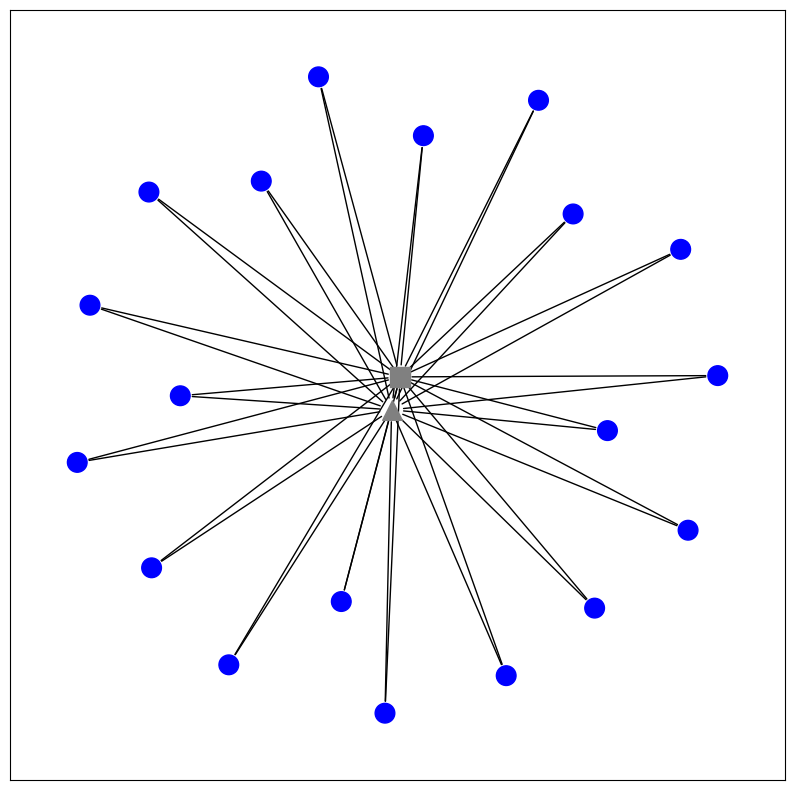

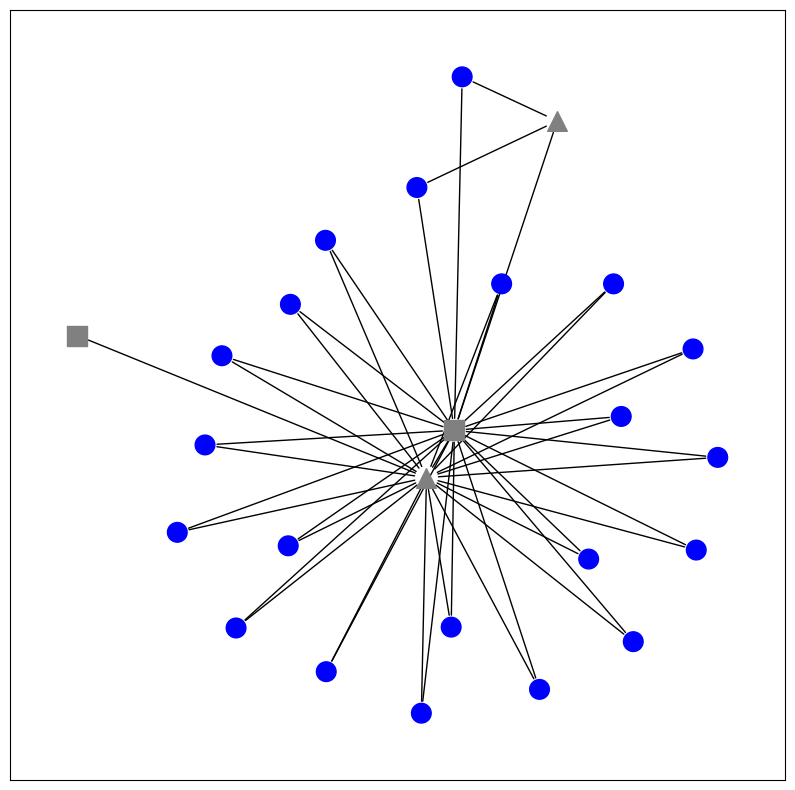

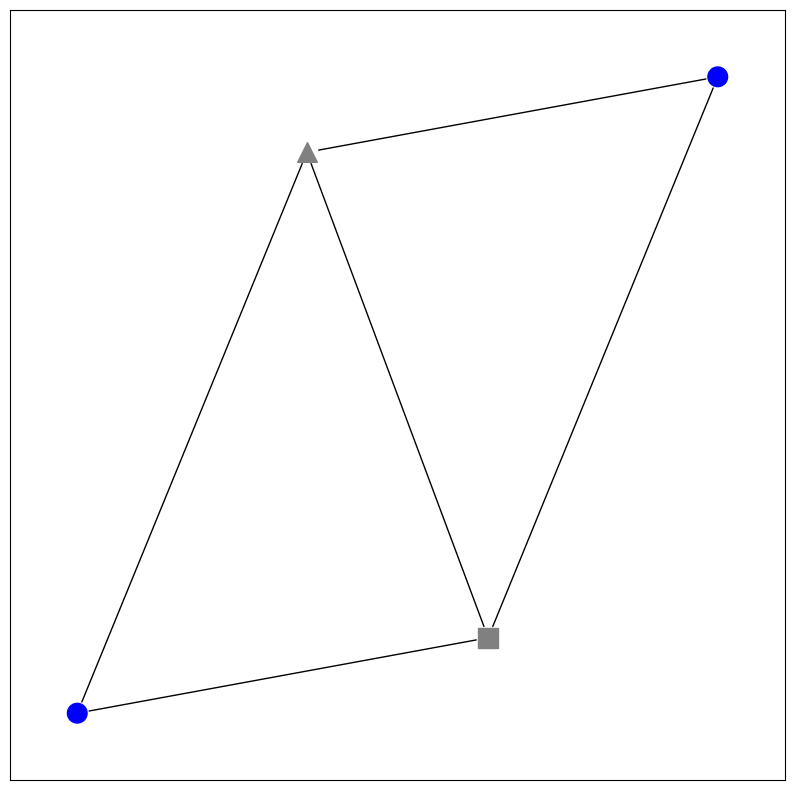

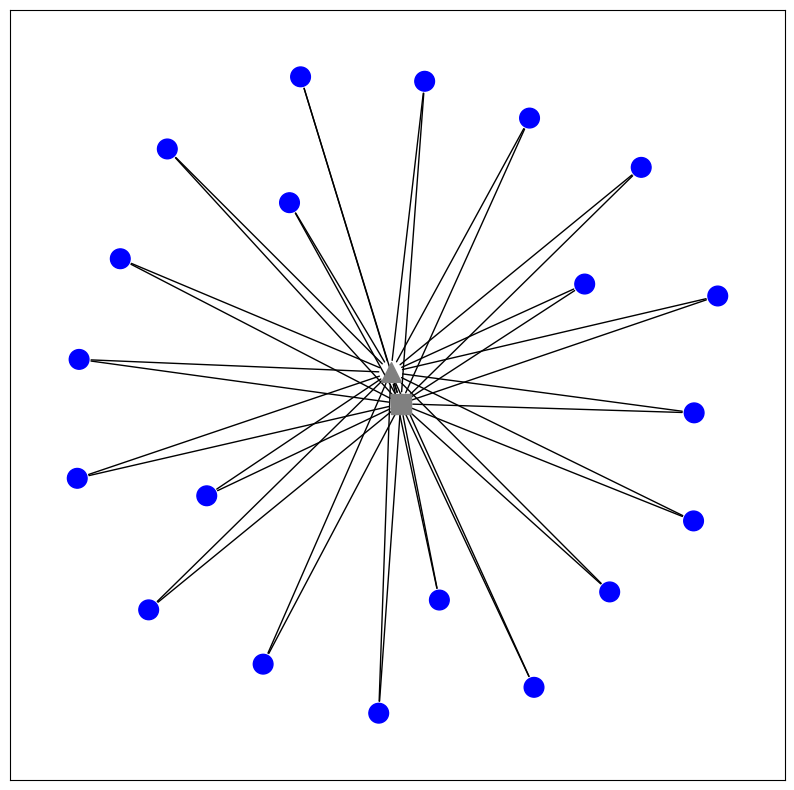

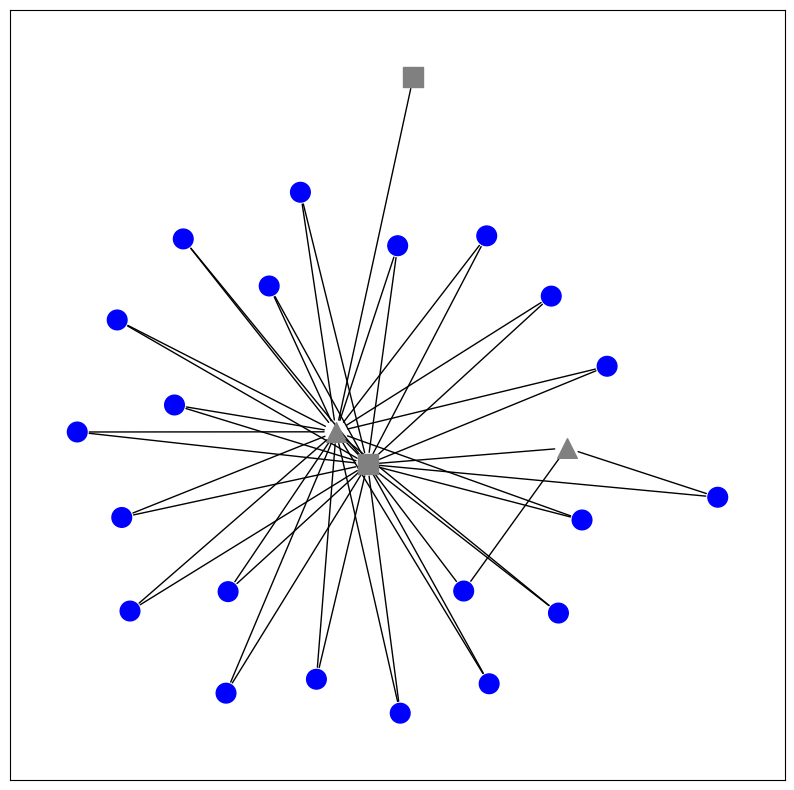

In [49]:
plot_neighborhood(dataloader_legit, N_plots=5)

In [50]:
dataloader_fraud = DataLoader(
    hg, {'txnIdx': np.where(y_txn==1)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

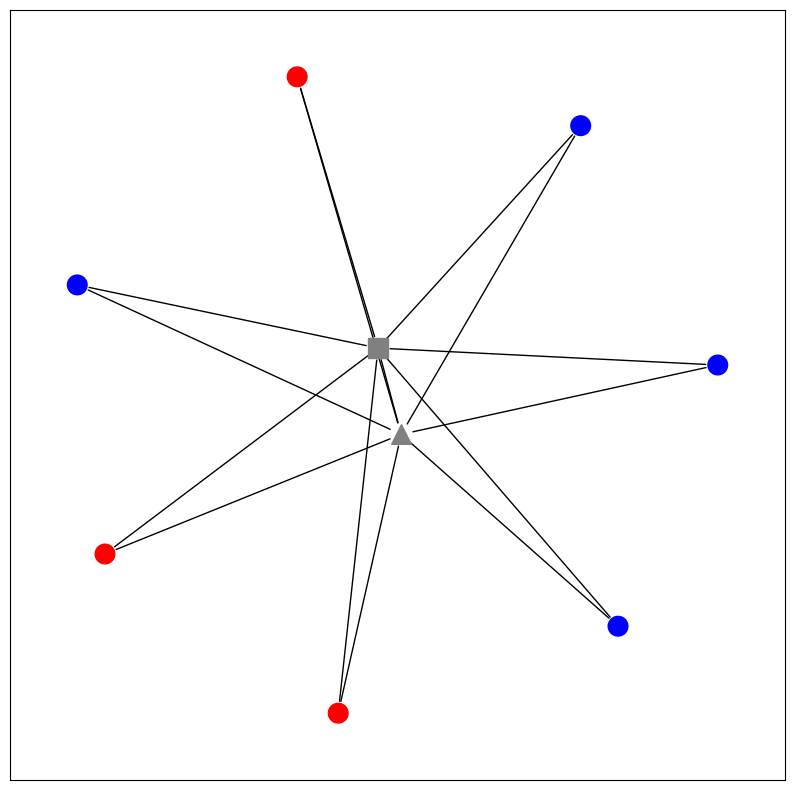

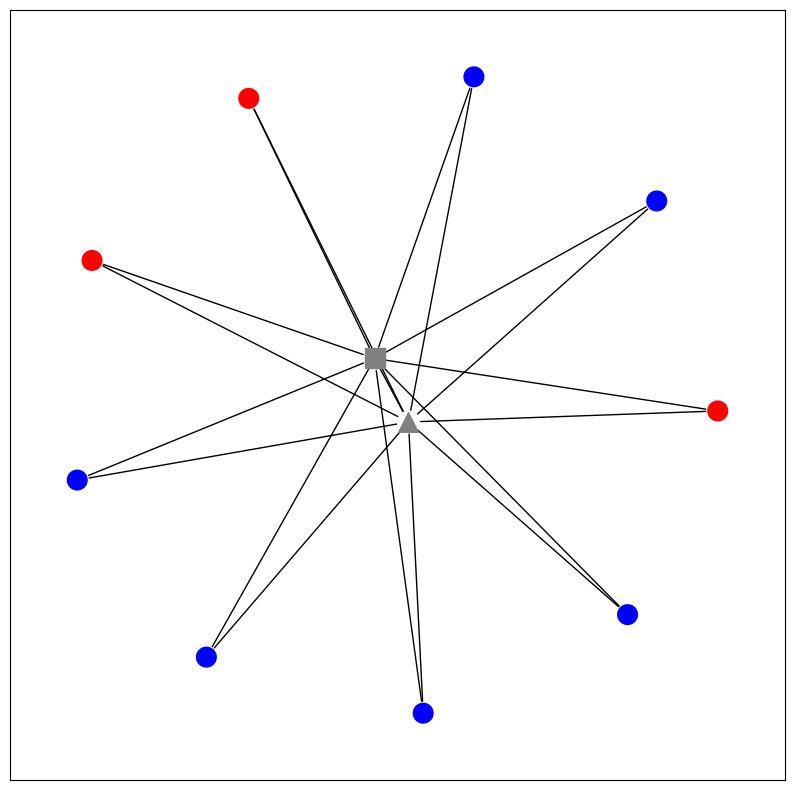

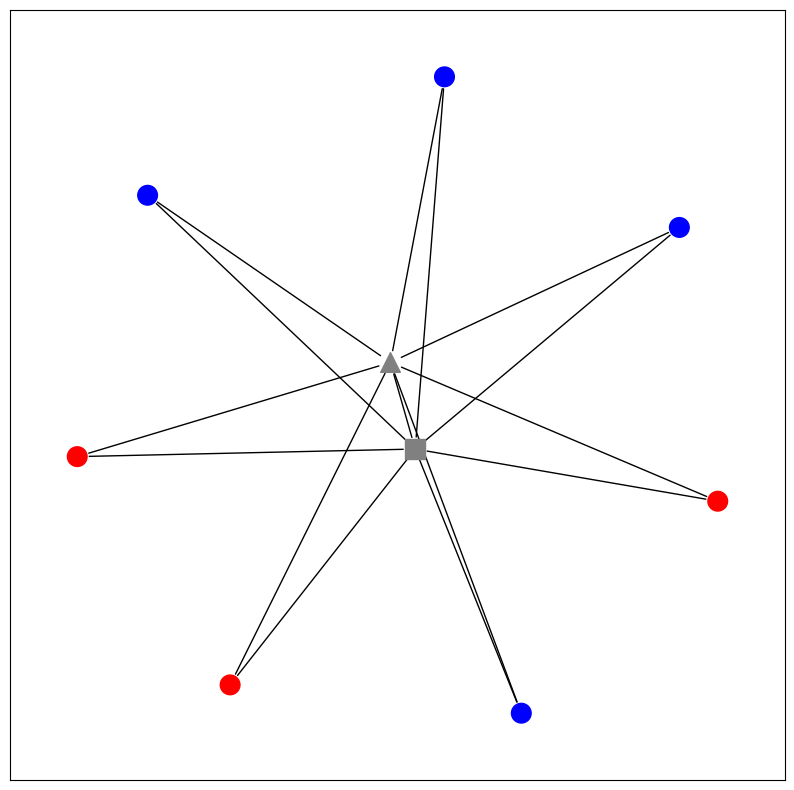

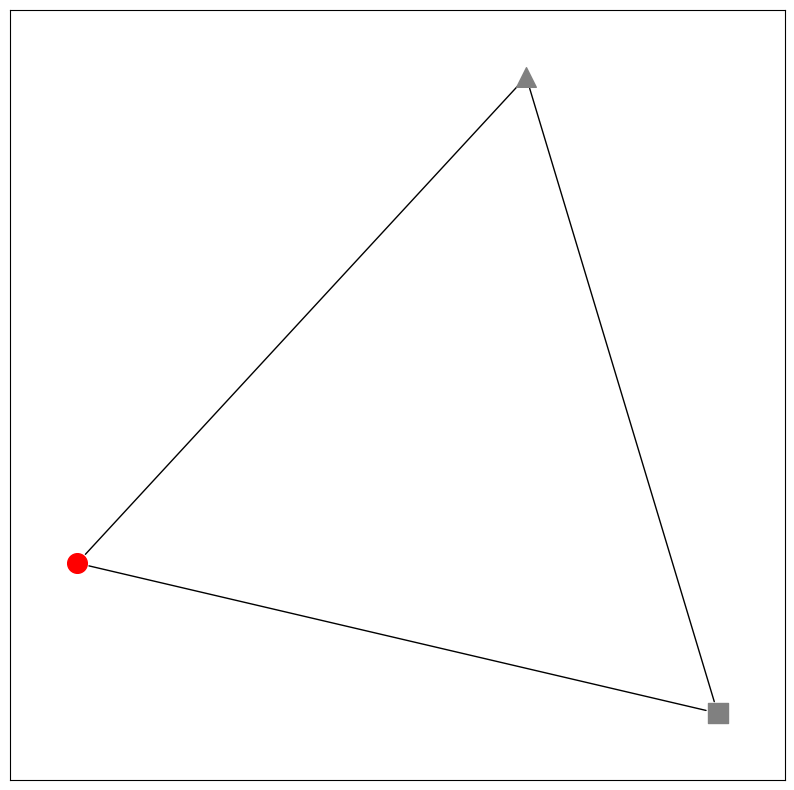

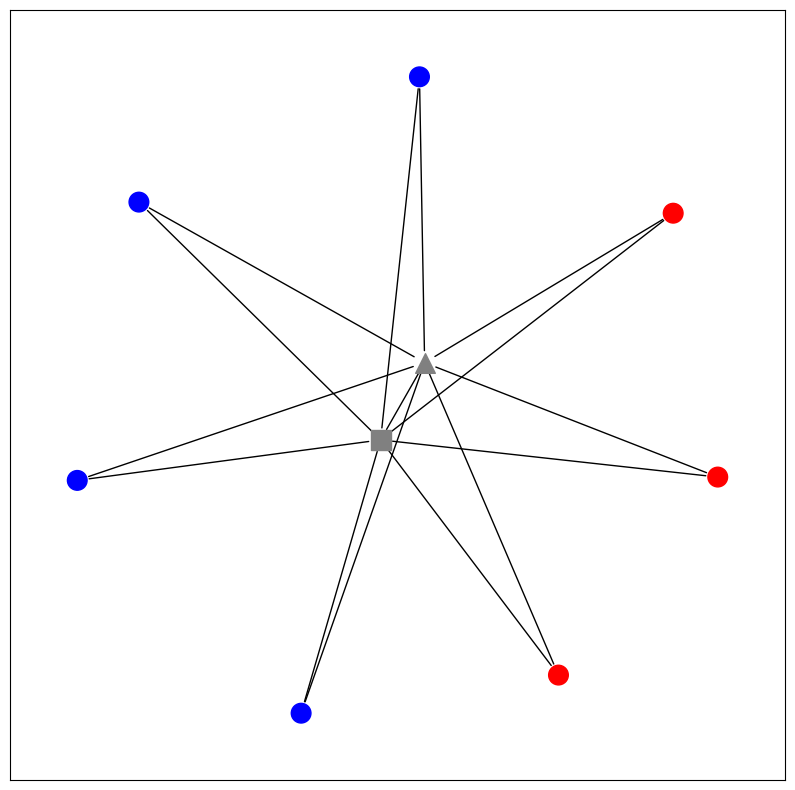

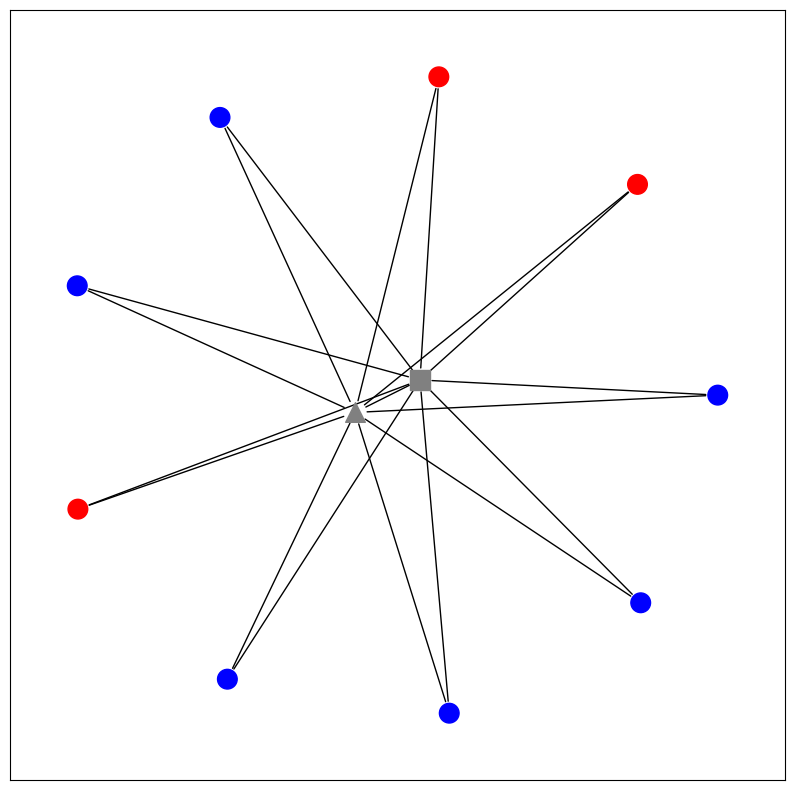

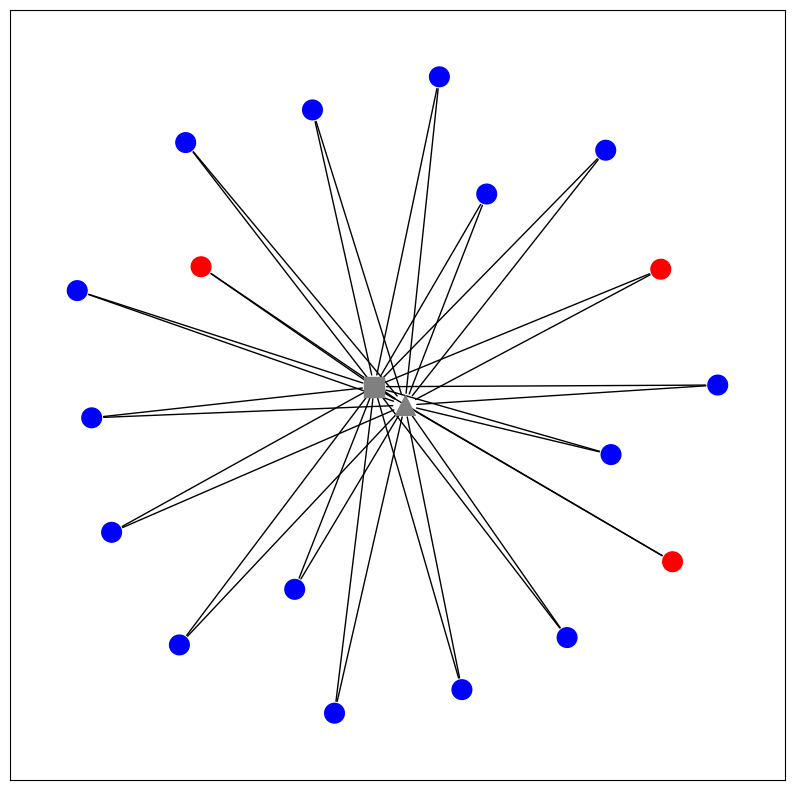

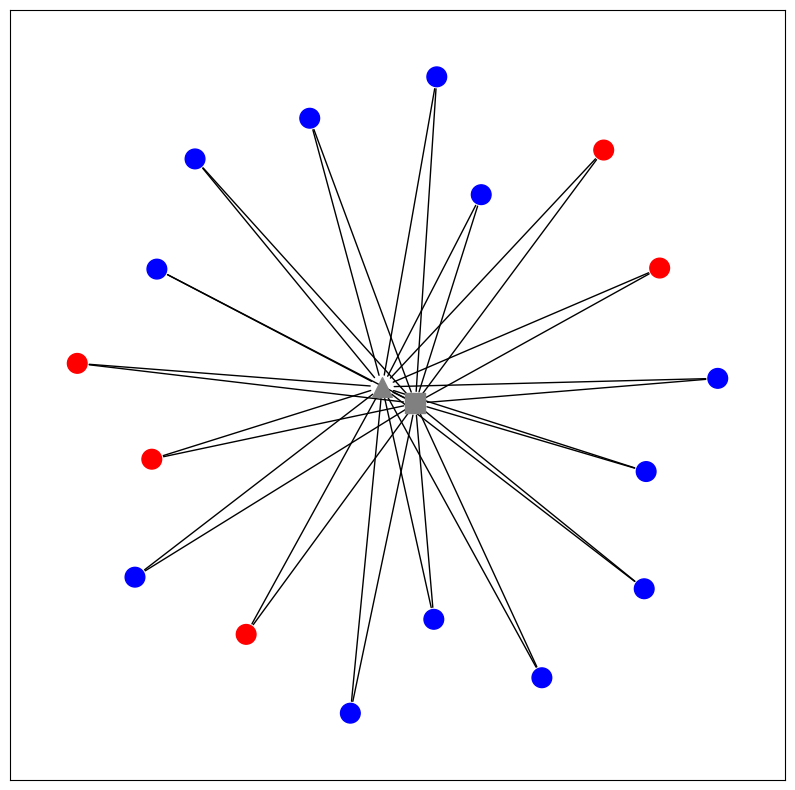

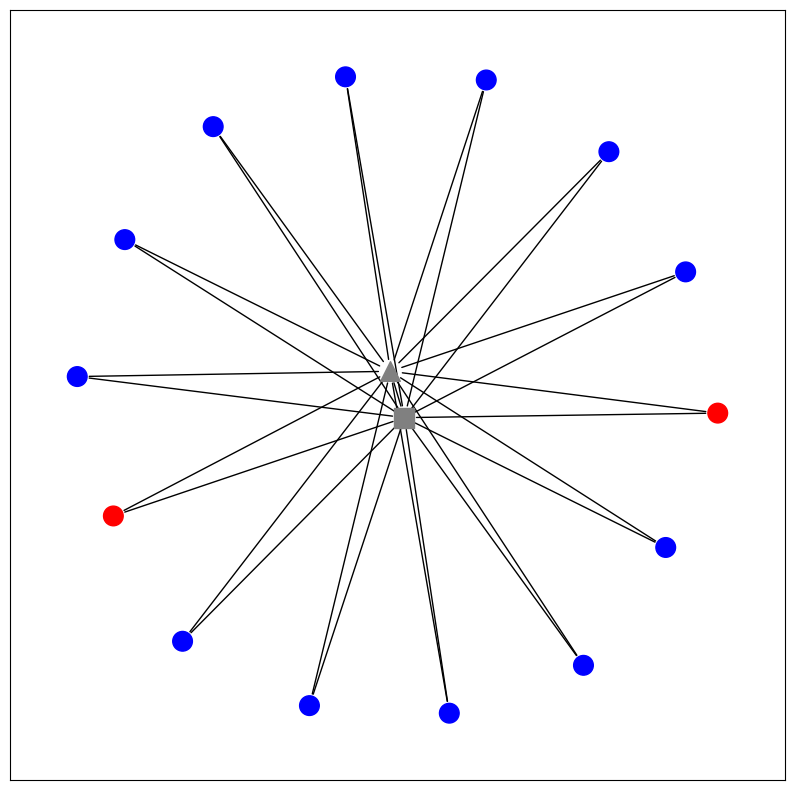

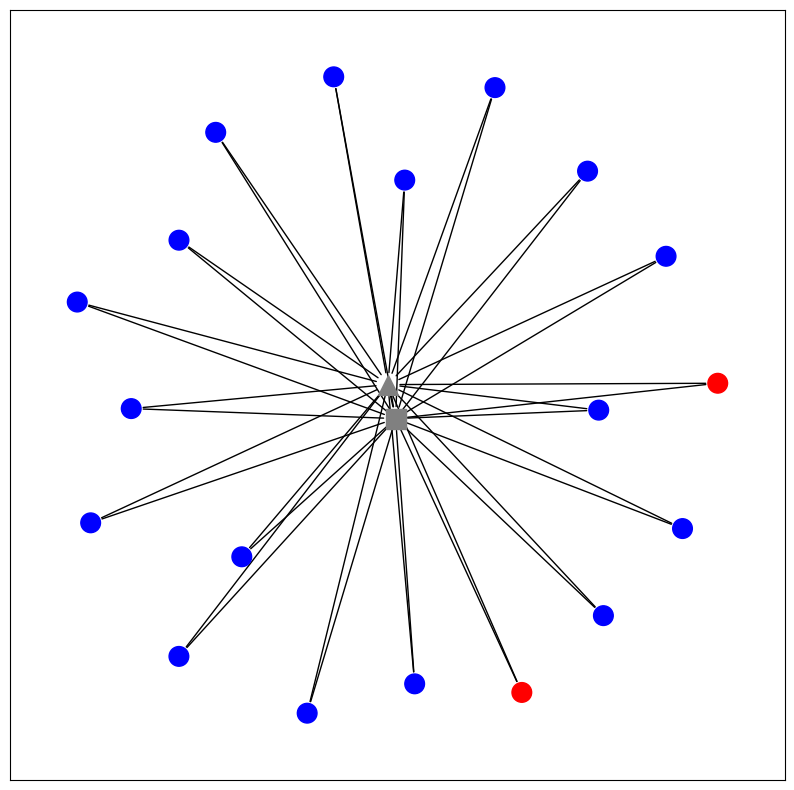

In [51]:
plot_neighborhood(dataloader_fraud, N_plots=10)

In [52]:
n_2hop, fraud_rate_2hop = neighborhood_stats(hg)

In [53]:
df_nstats = pd.DataFrame({
    'N_2hop': n_2hop[:N_labels],
    'fraud_rate_2hop': fraud_rate_2hop[:N_labels],
    'label': y_txn[:N_labels],
})

In [54]:
df_nstats.groupby('label').describe().T

label                           0.0           1.0
N_2hop          count  95469.000000    193.000000
                mean   30786.095703    812.088074
                std    41702.855469   6594.795410
                min        4.000000      4.000000
                25%       98.000000     32.000000
                50%      520.000000    102.000000
                75%    90171.000000    226.000000
                max    90171.000000  90171.000000
fraud_rate_2hop count  95469.000000    193.000000
                mean       0.001210      0.269275
                std        0.014854      0.221216
                min        0.000000      0.000022
                25%        0.000000      0.104167
                50%        0.000000      0.235294
                75%        0.000022      0.375000
                max        0.750000      0.750000

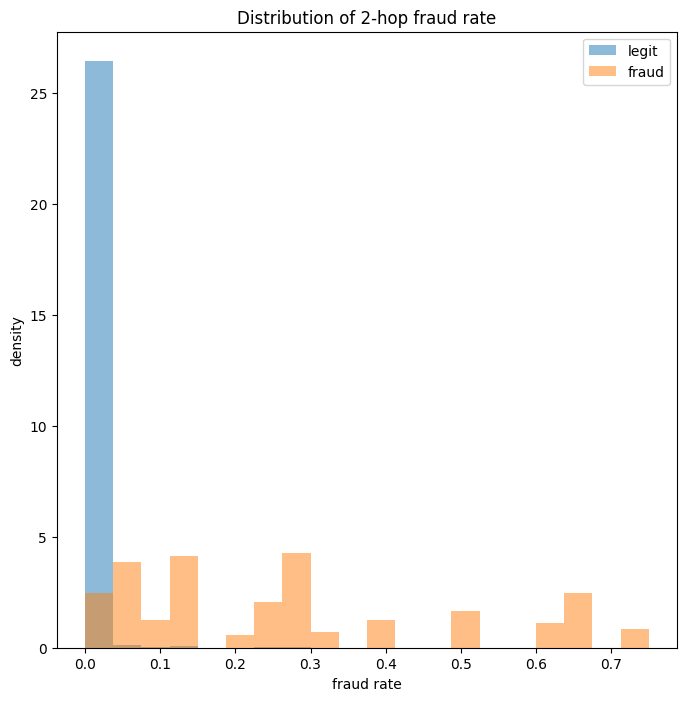

In [55]:
fig, ax = plt.subplots(figsize=(8,8))
_, bins, _ = ax.hist(df_nstats[df_nstats['label']==0]['fraud_rate_2hop'], bins=20, alpha=0.5, density=True, label='legit')
_ = ax.hist(df_nstats[df_nstats['label']==1]['fraud_rate_2hop'], bins=bins, alpha=0.5, density=True, label='fraud')
ax.set(xlabel='fraud rate', ylabel='density',
       title=f'Distribution of {n_hops}-hop fraud rate')
_ = ax.legend()

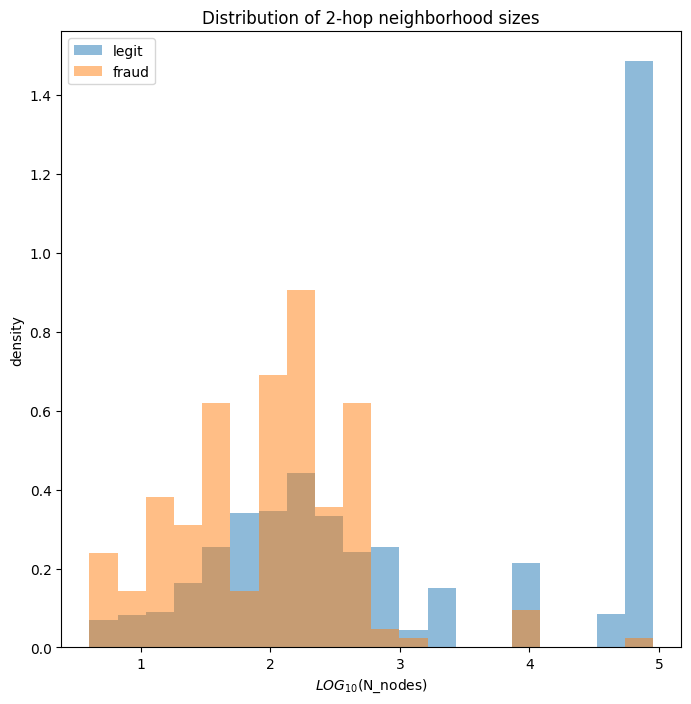

In [56]:
fig, ax = plt.subplots(figsize=(8,8))
_, bins, _ = ax.hist(
    np.log10(df_nstats[df_nstats['label']==0]['N_2hop']), bins=20, alpha=0.5, density=True, label='legit'
)
_ = ax.hist(
    np.log10(df_nstats[df_nstats['label']==1]['N_2hop']), bins=bins, alpha=0.5, density=True, label='fraud'
)
ax.set(xlabel='$LOG_{10}($N_nodes$)$', ylabel='density',
       title=f'Distribution of {n_hops}-hop neighborhood sizes')
_ = ax.legend()

## Node features

In [57]:
df.nunique().sort_values(ascending=False)

EnrollmentId           140681
txnIdx                 140681
EnrollmentStartTime    138574
stuIdx                   7479
StudentId                7479
AccountId                4841
acctIdx                  4841
SubscriptionId           4836
subIdx                   4836
Amount                   2099
Value                    1880
CourseId                   27
CourseCategory             10
ProviderId                  6
ChannelId                   5
PricingStrategy             4
CourseResult                2
dataset                     2
dtype: int64

In [58]:
categorical = ['ProviderId', 'CourseId', 'CourseCategory', 'ChannelId', 'PricingStrategy']

In [59]:
X_ohe = pd.get_dummies(df[categorical].astype(str), drop_first=True).values
X_amt = ((df['Amount']>0)*1).values
X_value = df['Value'].apply(np.log10).values

In [60]:
X_num = np.concatenate([X_amt.reshape((-1,1)), X_value.reshape((-1,1))], axis=1)
X_num = (X_num - X_num.mean(axis=0))/(X_num.max(axis=0) - X_num.min(axis=0))

In [61]:
X = np.concatenate([X_ohe, X_num], axis=1)

In [62]:
X.shape

(140681, 49)

In [63]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.40121267, -0.00782616],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.59878733, -0.26164142],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.40121267, -0.05279812],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.40121267,  0.14156744],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.59878733,  0.09659549],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.40121267,  0.07345412]])

## Modeling

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score,accuracy_score

In [216]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

def plot_pr(y_trues, y_preds, labels,c):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        auc = roc_auc_score(y_true, y_pred)
        pr, re, thresholds = precision_recall_curve(y_true, y_pred)
        ax.plot(re, pr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

        f1_scores = 2*re*pr/(re+pr)
        best_threshold=thresholds[np.argmax(f1_scores)]
        if(c==0):
          y_pred_binary = (y_pred >= best_threshold).astype(int)
          accuracy = accuracy_score(y_true, y_pred_binary)
        else:
          y_true = th.tensor(y_trues[i])
          y_pred = th.tensor(y_preds[i])
          y_pred_binary = th.round(y_pred)
          accuracy= metrics(y_true, y_pred_binary)
        print(labels[i])
        print('Best threshold: ', best_threshold)
        print('Best F1-Score: ', np.max(f1_scores))
        print('Best Accuracy: ', accuracy)
    ax.legend()
    ax.grid()
    ax.set_title('Precision-Recall curve')
    ax.set_xlabel('Recall')
    _ = ax.set_ylabel('Precision')

def metrics(preds, gts):
  preds = th.round(th.cat([preds]))
  gts = th.cat([gts])
  acc = accuracy_score(preds, gts)
  return acc


In [217]:
baseline

0.00201752001839811

In [218]:
labeled_mask = np.zeros_like(y_txn, dtype=bool)
labeled_mask[:N_labels] = 1
assert y_txn[labeled_mask].mean()==baseline

In [219]:
rng = np.random.default_rng(1)
train_rate = 0.7
train_mask = (rng.random(y_txn.shape[0])>(1-train_rate))&labeled_mask
val_mask = ~train_mask&labeled_mask

In [220]:
test_mask = ~labeled_mask

In [221]:
y_txn[train_mask].mean(), y_txn[val_mask].mean()

(0.0019413706076490001, 0.002195198438969999)

In [222]:
y_txn[train_mask].sum(), y_txn[val_mask].sum()

(130.0, 63.0)

### Logistic Regression / RF

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [224]:
clf = LogisticRegression()
clf.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_lr = clf.predict_proba(X[val_mask,:])
y_val_lr = clf.predict(X[val_mask,:])

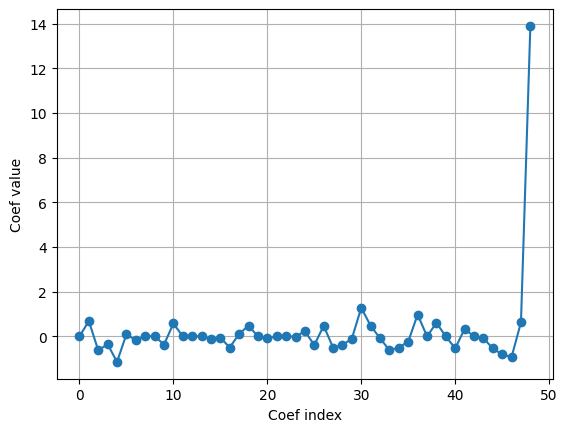

In [225]:
fig, ax = plt.subplots()
ax.plot(clf.coef_[0,:], '-o')
ax.set(xlabel='Coef index', ylabel='Coef value')
_ = ax.grid()

In [226]:
corrs = list()
for col in range(X.shape[1]):
    corr = np.corrcoef(X[train_mask,col], y_txn[train_mask])[0,1]
    corrs.append(corr)
corrs = np.array(corrs)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


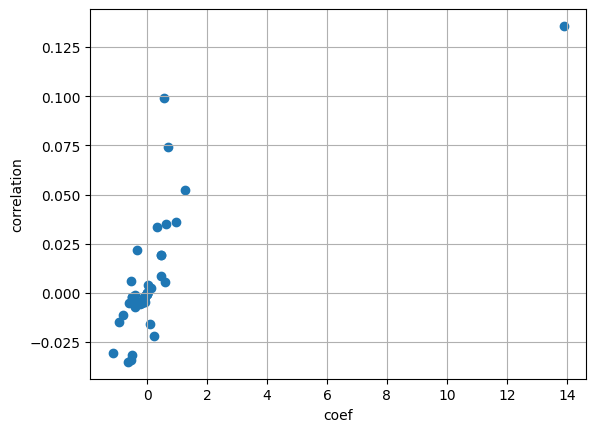

In [227]:
fig, ax = plt.subplots()
ax.scatter(x=clf.coef_[0,:], y=corrs)
ax.set(xlabel='coef', ylabel='correlation')
_ = ax.grid()

In [228]:
np.flip(np.argsort(np.nan_to_num(corrs, nan=-2)))

array([48, 10,  1, 30, 36, 47, 41,  3, 26, 31, 18, 44, 38,  8, 17, 19,  7,
       37, 11,  0, 23, 28, 32, 20, 29, 34, 16, 15,  9, 14, 43, 33,  6, 35,
       25, 45, 46,  5, 24,  4, 27, 40,  2, 13, 12, 39, 42, 22, 21])

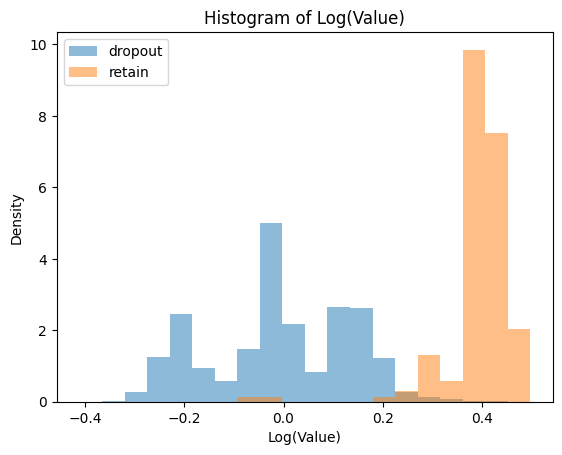

In [229]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(X[y_txn==0,48], bins=20, label='dropout', density=True, alpha=0.5)
_ = ax.hist(X[y_txn==1,48], bins=bins, label='retain', density=True, alpha=0.5)
ax.legend()
_ = ax.set(xlabel='Log(Value)', ylabel='Density', title='Histogram of Log(Value)')

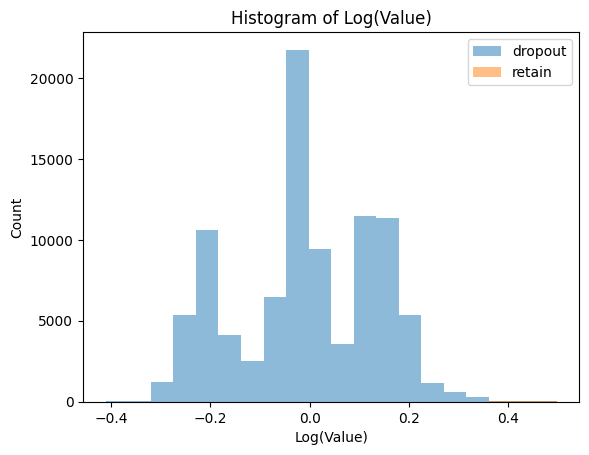

In [230]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(X[y_txn==0,48], bins=20, label='dropout', density=False, alpha=0.5)
_ = ax.hist(X[y_txn==1,48], bins=bins, label='retain', density=False, alpha=0.5)
ax.legend()
_ = ax.set(xlabel='Log(Value)', ylabel='Count', title='Histogram of Log(Value)')

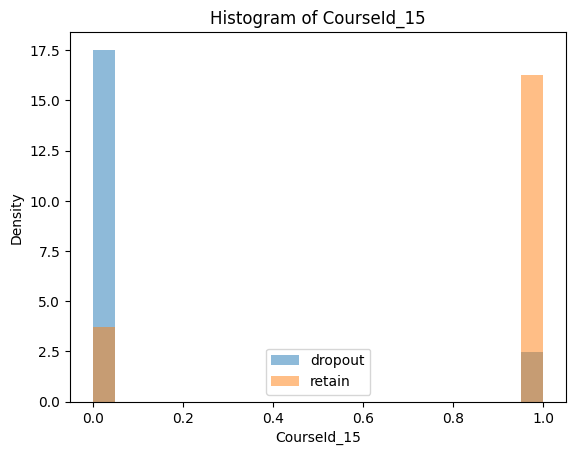

In [231]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(X[y_txn==0,10], bins=20, label='dropout', density=True, alpha=0.5)
_ = ax.hist(X[y_txn==1,10], bins=bins, label='retain', density=True, alpha=0.5)
ax.legend()
_ = ax.set(xlabel='CourseId_15', ylabel='Density', title='Histogram of CourseId_15')

In [232]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_rf = rf.predict_proba(X[val_mask,:])
y_val_rf = rf.predict(X[val_mask,:])
rf

RandomForestClassifier(n_estimators=300)

In [233]:
clf_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
clf_balanced.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_lrb = clf_balanced.predict_proba(X[val_mask,:])
y_val_lrb = clf_balanced.predict(X[val_mask,:])

In [234]:
y_hat_test_lr = clf.predict_proba(X[test_mask,:])
y_test_lr = clf.predict(X[test_mask,:])

y_hat_test_lrb = clf_balanced.predict_proba(X[test_mask,:])
y_test_lrb = clf_balanced.predict(X[test_mask,:])

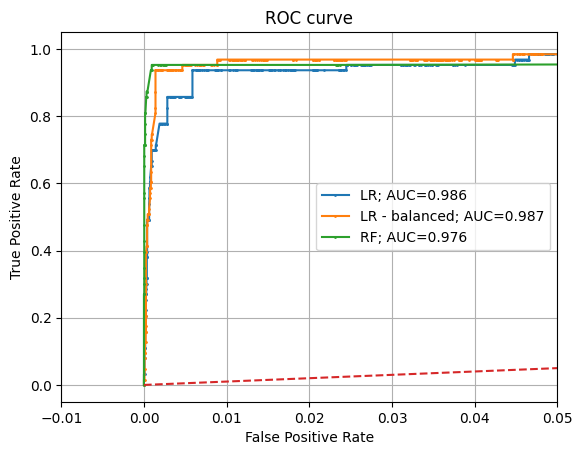

In [235]:
plot_roc(
    [y_txn[val_mask]]*3,
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1]],
    ['LR', 'LR - balanced', 'RF'],
    x_max=0.05,
)

LR
Best threshold:  0.11474674354729134
Best F1-Score:  0.6567164179104478
Best Accuracy:  0.9983971566953552
LR - balanced
Best threshold:  0.9586210133771274
Best F1-Score:  0.7283950617283951
Best Accuracy:  0.9984668455346877
RF
Best threshold:  0.14493783068783073
Best F1-Score:  0.8661417322834646
Best Accuracy:  0.9994076448656748


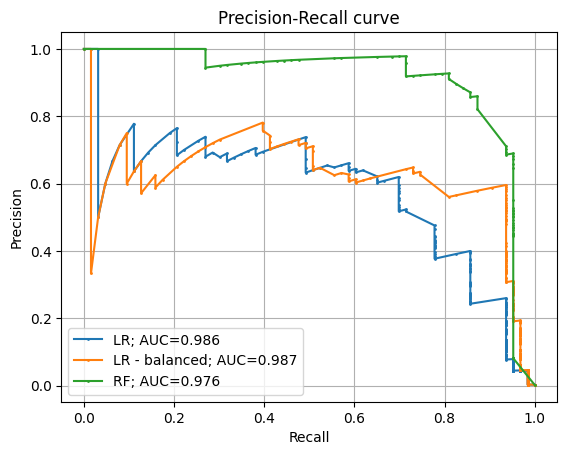

In [236]:
c=0
plot_pr(
    [y_txn[val_mask]]*3,
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1]],
    ['LR', 'LR - balanced', 'RF'],c
)

### Adding graph features


In [237]:
X_fr = fraud_rate_2hop.numpy()[:N_labels]
X_fr = (X_fr - X_fr.mean(axis=0))/(X_fr.max(axis=0) - X_fr.min(axis=0))
assert X_fr.shape[0] == N_labels

In [238]:
X_fr_full = np.zeros(X.shape[0])
X_fr_full[:N_labels] = X_fr
X.shape, X_fr_full.shape

((140681, 49), (140681,))

In [239]:
X_mod = np.hstack([X, X_fr_full.reshape((-1, 1))])
X.shape, X_mod.shape

((140681, 49), (140681, 50))

In [240]:
clf_fr = LogisticRegression()
clf_fr.fit(X_mod[train_mask,:], y_txn[train_mask])

y_hat_val_lr_fr = clf_fr.predict_proba(X_mod[val_mask,:])
y_val_lr_fr = clf_fr.predict(X_mod[val_mask,:])

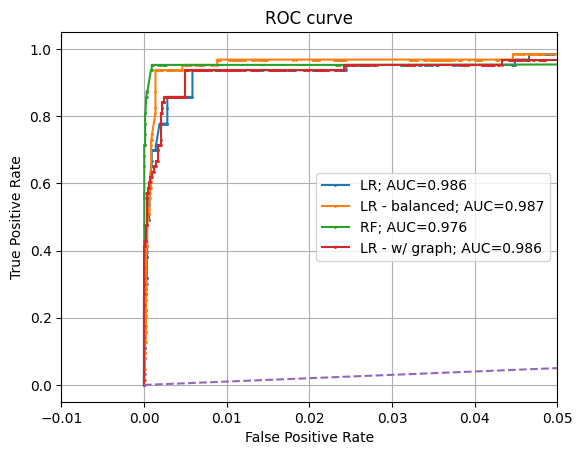

In [241]:
plot_roc(
    [y_txn[val_mask]]*4,
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_hat_val_lr_fr[:,1]],
    ['LR', 'LR - balanced', 'RF', 'LR - w/ graph'],
    x_max=0.05,
)

LR
Best threshold:  0.11474674354729134
Best F1-Score:  0.6567164179104478
Best Accuracy:  0.9980835569183595
LR - balanced
Best threshold:  0.9586210133771274
Best F1-Score:  0.7283950617283951
Best Accuracy:  0.9886755636084881
RF
Best threshold:  0.14493783068783073
Best F1-Score:  0.8661417322834646
Best Accuracy:  0.99926826718701
LR - w/ graph
Best threshold:  0.2735230183283443
Best F1-Score:  0.6545454545454545
Best Accuracy:  0.9986062232133524


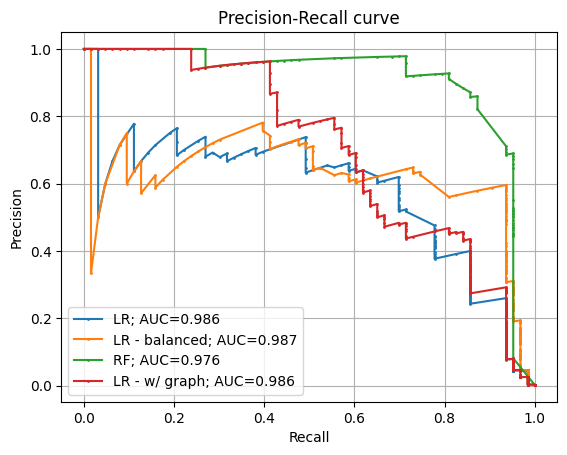

In [242]:
c=1
plot_pr(
    [y_txn[val_mask]]*4,
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_hat_val_lr_fr[:,1]],
    ['LR', 'LR - balanced', 'RF', 'LR - w/ graph'],c
)

### Label Propagation

In [243]:
from scipy.sparse import diags

In [244]:
def label_propagation(g, baseline, train_mask, alpha=0.8, iters=20, warmup=10, dgl=False):
    labels = g.ndata['label']
    txn_idx = g.ndata['_TYPE']==g.ndata['_TYPE'].max().item() # the transaction nodes
    train_mask_g = th.zeros_like(labels).bool()
    train_mask_g[th.where(txn_idx)[0][train_mask]] = 1


    s = th.zeros((labels.shape[0], 2))
    s[:,0] = 1 - baseline
    s[:,1] = baseline

    s[(labels==0)&(train_mask_g),0] = 1
    s[(labels==0)&(train_mask_g),1] = 0

    s[(labels==1)&(train_mask_g),0] = 0
    s[(labels==1)&(train_mask_g),1] = 1


    assert (s.sum(dim=1)==1).float().mean()==1

    y_train = s.clone().detach()
    y_preds = list()


    if dgl:
        print('dgl')
        with g.local_scope():
            src, dst = g.edges()
            src_d = g.in_degrees(src).float()
            dst_d = g.in_degrees(dst).float()
            g.edata['w'] = 1/th.sqrt(dst_d) * 1/th.sqrt(src_d)
            g.update_all(fn.copy_e('w', 'm'), fn.sum('m', 'w_total'))
            g.apply_edges(fn.e_div_v('w', 'w_total', 'w_norm'))

            for e in range(iters):
                g.ndata['feat'] = s
                g.update_all(
                    fn.u_mul_e('feat', 'w_norm', 'm'),
                    fn.sum('m', 'h')
                )
                h = g.ndata['h']

                s = alpha*h + (1-alpha)*y_train

                if e >= warmup:
                    y_preds.append(s[th.where(txn_idx)[0]])


    else:
        print("no dgl")
        adj = g.adj(transpose=True, scipy_fmt='coo')
        d_inv_root = diags(np.sqrt(1/adj.sum(axis=1)).flatten().tolist()[0])
        a_scaled = d_inv_root @ adj @ d_inv_root
        norm = diags((1/a_scaled.sum(axis=1)).flatten().tolist()[0])
        w = (norm @ a_scaled).tocoo()
        w = th.sparse_coo_tensor(np.stack([w.row, w.col]), w.data).float()

        for e in range(iters):
            h = (w @ s)
            s = alpha*h + (1-alpha)*y_train

            if e >= warmup:
                y_preds.append(s[th.where(txn_idx)[0]])

    return y_preds


In [245]:
g = dgl.to_homogeneous(hg, ndata=['label'])

In [246]:
txnTypeIdx = g.ndata['_TYPE'].max().item()
assert th.equal(
    g.ndata['label'][g.ndata['_TYPE']==txnTypeIdx],
    th.tensor(np.nan_to_num(y_txn, nan=baseline)).float(),
)

assert np.array_equal(
    g.ndata['label'][g.ndata['_TYPE']==txnTypeIdx][train_mask].numpy(),
    y_txn[train_mask]
)

In [247]:
y_lps = label_propagation(g, baseline, train_mask, alpha=0.5, iters=20, warmup=10, dgl=True)

dgl


In [248]:
y_test_lp = y_lps[-1][test_mask,:]

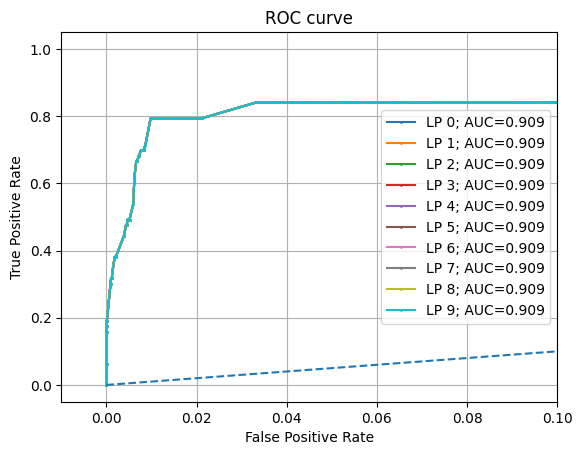

In [249]:
# DGL
plot_roc(
    [y_txn[val_mask]]*len(y_lps),
    [y[val_mask,1] for y in y_lps],
    [f'LP {i}' for i in range(len(y_lps))],
    x_max=0.1,
)

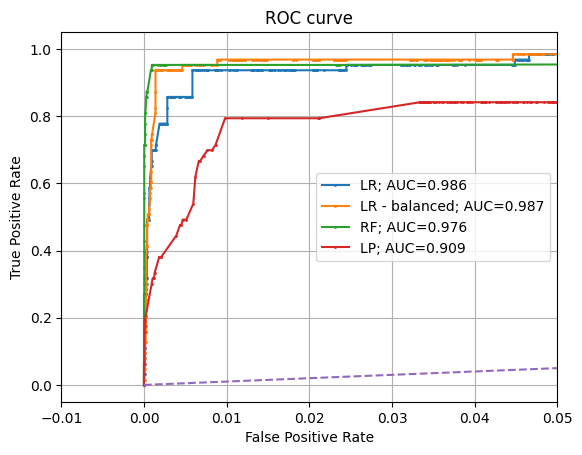

In [250]:
plot_roc(
    [y_txn[val_mask]]*4,
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1]],
    ['LR', 'LR - balanced', 'RF', 'LP'],
    x_max=0.05,
)

LR
Best threshold:  0.11474674354729134
Best F1-Score:  0.6567164179104478
Best Accuracy:  0.9980835569183595
LR - balanced
Best threshold:  0.9586210133771274
Best F1-Score:  0.7283950617283951
Best Accuracy:  0.9886755636084881
RF
Best threshold:  0.14493783068783073
Best F1-Score:  0.8661417322834646
Best Accuracy:  0.99926826718701
LP
Best threshold:  0.037686184
Best F1-Score:  0.35398230088495575
Best Accuracy:  0.99780480156103


<ipython-input-216-481ace2b142b>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = th.tensor(y_preds[i])


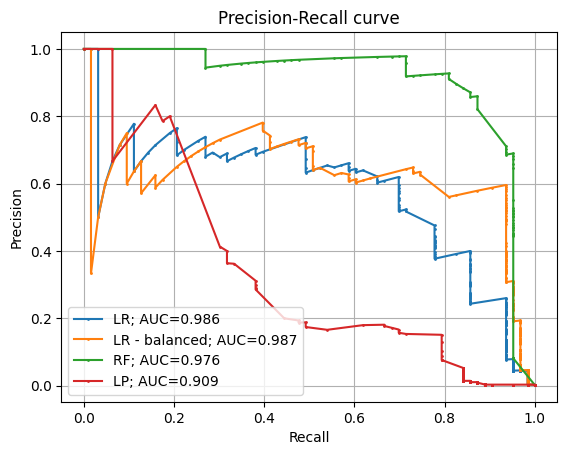

In [253]:
c=1
plot_pr(
    [y_txn[val_mask]]*4,
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1]],
    ['LR', 'LR - balanced', 'RF', 'LP'],c
)

### GNNs

In [254]:
from dgl.nn import GraphConv, HeteroGraphConv, WeightBasis

In [255]:
def plot_losses(train_losses, val_losses, log=False):
    """
    Plots train/validation loss curves vs training epoch
    """
    fig, ax = plt.subplots()

    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Val')
    ax.set(xlabel='Epoch', ylabel='CrossEnt')
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.grid()

@th.no_grad()
def infer(model_cp, hg, mask, best_model_fp=None):
    if best_model_fp:
        print("loading from disk")
        model = deepcopy(model_cp)
        model.load_state_dict(th.load(best_model_fp))
    else:
        model = model_cp

    model.to(device)

    model.eval()

    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)

    y_preds = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        y_preds.append(logits.softmax(dim=1))

    return th.cat(y_preds).cpu()

@th.no_grad()
def test(model, hg, mask, best_path=None):

    model.eval()

    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)

    labels = hg.ndata['label']['txnIdx'].long()


    correct = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        y_preds = logits.argmax(1)
        n_correct = (labels[output_nodes['txnIdx']]==y_preds).sum().item()
        correct.append((labels[output_nodes['txnIdx']]==y_preds).sum().item())


    acc = sum(correct)/(th.where(mask)[0].shape[0])

    return acc

def train_step(model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight=False):
    """
    A single training step
    """
    model.train()
    optimizer.zero_grad()

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = DataLoader(
        hg, {'txnIdx': th.where(train_mask)[0]}, sampler,
        batch_size=1024, shuffle=True, drop_last=False, num_workers=0)

    val_loader = DataLoader(
        hg, {'txnIdx': th.where(val_mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)

    train_losses = list()
    if weight:
        weight = th.tensor([1., 1/baseline]).float().to(device)
    else:
        weight = None

    labels = hg.ndata['label']['txnIdx'].long()

    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]

        logits = model(blocks, h)
        loss = loss_fn(logits, labels[output_nodes['txnIdx']], weight=weight)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_losses.append(loss.item())


    val_losses = list()
    with th.no_grad():
        for input_nodes, output_nodes, blocks in val_loader:
            h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
            blocks = [b.to(device) for b in blocks]

            logits = model(blocks, h)
            val_loss = loss_fn(logits, labels[output_nodes['txnIdx']])
            val_losses.append(val_loss.item())

    return np.array(train_losses).mean(), np.array(val_losses).mean()

def train(hg, split_idx, model, epochs, evaluator,
          device, save_path, loss_fn=F.cross_entropy, lr=0.01,
          es_criteria=5, weight_class=False, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_metric = 1e10
    train_losses = list()
    val_losses = list()

    features = hg.ndata['feat']

    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    es_iters = 0

    for e in range(1, epochs+1):

        train_loss, val_loss = train_step(
            model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight_class,
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)


        train_acc = test(model, hg, train_mask)
        val_acc = test(model, hg, val_mask)

        val_metric = val_loss

        if val_metric > 1e5:
            print(f"Early stopping for huge loss: {val_metric}")
            break

        if val_metric < best_val_metric  :
            best_val_metric = val_metric
            th.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1


        if e % 5 == 0 and verbose:


            print('In epoch {}, loss: {:.3f}, val metric: {:.3f} (best {:.3f})'.format(
                e, train_loss, val_metric, best_val_metric))

        if es_iters >= es_criteria:
            print(f"Early stopping at {e} epochs")
            break

    return np.array(train_losses), np.array(val_losses)

In [256]:
class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 *,
                 num_bases=None,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 bn=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.bn = bn

        self.conv = HeteroGraphConv({
                rel : GraphConv(in_feat, out_feat, norm='right', weight=False, bias=False)
                for rel in rel_names
            })

        self.use_weight = weight
        self.use_basis = num_bases is not None and num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))

        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))

        if self.bn:
            self.bn_layer = nn.BatchNorm1d(out_feat)

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs

        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.bn:
                h = self.bn_layer(h)
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

In [257]:
class RGCN(nn.Module):
    def __init__(self, hg, in_feats, h_feats, num_classes, num_layers, num_bases,
                 self_loop=True, dropout=0, bn=False):

        super(RGCN, self).__init__()
        self.dropout = dropout

        self.convs = nn.ModuleList()
        activation_fn = nn.ReLU()
        self.convs.append(RelGraphConvLayer(
            in_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout,
            num_bases=num_bases, self_loop=self_loop, bn=bn))

        for _ in range(num_layers-1):
            self.convs.append(RelGraphConvLayer(
                h_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout,
                num_bases=num_bases, self_loop=self_loop, bn=bn
            ))

        self.output_layer = nn.Linear(h_feats+in_feats, num_classes)

    def forward(self, blocks, in_feat):
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features

        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
        """
        h = in_feat
        for i, conv in enumerate(self.convs):
            h = conv(blocks[i], h)

        h_in = blocks[-1].dstdata['feat']['txnIdx']
        h = self.output_layer(th.cat([h['txnIdx'], h_in], dim=1))
        return h


class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target, weight=None):
        logprobs = nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [258]:
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        X_tmp = th.tensor(X).float()
    else:

        X_rand = th.rand((hg.num_nodes(ntype), X.shape[1]-1))-0.5

        print(ntype, hg.num_nodes(ntype))
        in_degrees = th.zeros(hg.num_nodes(ntype))
        for cetype in hg.canonical_etypes:
            if ntype==cetype[2]:
                print(cetype)
                in_degrees += hg.in_degrees(etype=cetype)
        in_degrees = th.log(in_degrees).reshape((-1, 1))
        in_degrees -= in_degrees.mean()

        X_tmp = th.hstack([X_rand, in_degrees])
    hg.nodes[ntype].data['feat'] = X_tmp

acctIdx 4841
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
subIdx 4836
('acctIdx', 'acctIdx-subIdx', 'subIdx')
('txnIdx', 'txnIdx-subIdx', 'subIdx')


In [259]:
split_mask = {
    'train': th.tensor(train_mask),
    'valid': th.tensor(val_mask),
    'test': th.tensor(test_mask)
}

In [260]:
loss_fn = LabelSmoothing(smoothing=0.1)

In [261]:
model_kwargs = dict(
    in_feats=X.shape[1], h_feats=256, num_classes=2,
    num_layers=2, dropout=0.1, num_bases=None,
    self_loop=False, bn=True,
)
model = RGCN(hg, **model_kwargs).to(device)
model

RGCN(
  (convs): ModuleList(
    (0): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acctIdx-subIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (acctIdx-txnIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (subIdx-acctIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (subIdx-txnIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (txnIdx-acctIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
          (txnIdx-subIdx): GraphConv(in=49, out=256, normalization=right, activation=None)
        )
      )
      (bn_layer): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acctIdx-subI

In [262]:
train_losses, val_losses = train(
    hg.to(device), split_mask, model.to(device), 50, None,
    device, 'models/rgcn.pt', loss_fn=loss_fn, lr=0.001,
    es_criteria=50, verbose=True, weight_class=True,
)

/usr/local/lib/python3.10/dist-packages/dgl/dataloading/dataloader.py:1149: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


In epoch 5, loss: 0.220, val metric: 0.232 (best 0.217)
In epoch 10, loss: 0.221, val metric: 0.218 (best 0.209)
In epoch 15, loss: 0.214, val metric: 0.215 (best 0.209)
In epoch 20, loss: 0.206, val metric: 0.209 (best 0.207)
In epoch 25, loss: 0.206, val metric: 0.214 (best 0.205)
In epoch 30, loss: 0.205, val metric: 0.205 (best 0.205)
In epoch 35, loss: 0.205, val metric: 0.208 (best 0.205)
In epoch 40, loss: 0.205, val metric: 0.206 (best 0.205)
In epoch 45, loss: 0.204, val metric: 0.205 (best 0.205)
In epoch 50, loss: 0.204, val metric: 0.205 (best 0.205)


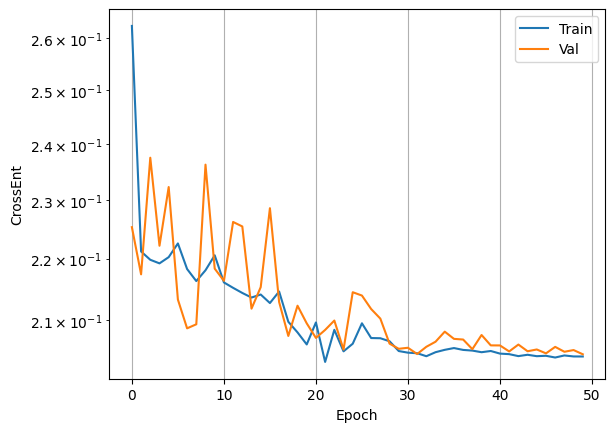

In [263]:
plot_losses(train_losses, val_losses, log=True)

In [264]:
y_val_hat_rgcn = infer(model.to(device), hg.to(device), split_mask['valid'].to(device), 'models/rgcn.pt')

loading from disk


LR
Best threshold:  0.11474674354729134
Best F1-Score:  0.6567164179104478
Best Accuracy:  0.9980835569183595
LR - balanced
Best threshold:  0.9586210133771274
Best F1-Score:  0.7283950617283951
Best Accuracy:  0.9886755636084881
RF
Best threshold:  0.14493783068783073
Best F1-Score:  0.8661417322834646
Best Accuracy:  0.99926826718701
LP
Best threshold:  0.037686184
Best F1-Score:  0.35398230088495575
Best Accuracy:  0.99780480156103
RGCN
Best threshold:  0.11210847
Best F1-Score:  0.29437229437229434
Best Accuracy:  0.99780480156103


<ipython-input-216-481ace2b142b>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = th.tensor(y_preds[i])
<ipython-input-216-481ace2b142b>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = th.tensor(y_preds[i])


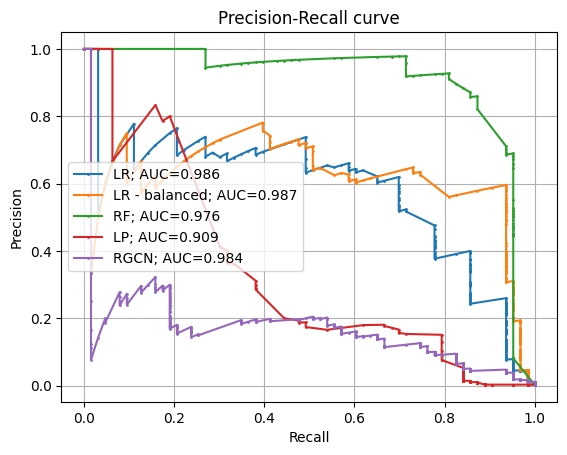

In [266]:
c=1
plot_pr(
    [y_txn[val_mask]]*5,
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1], y_val_hat_rgcn[:,1]],
    ['LR', 'LR - balanced', 'RF', 'LP', 'RGCN'],c
)

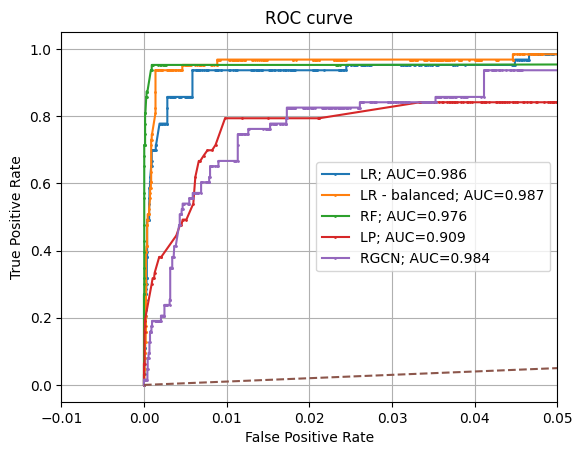

In [267]:
plot_roc(
    [y_txn[val_mask]]*5,
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1], y_val_hat_rgcn[:,1]],
    ['LR', 'LR - balanced', 'RF', 'LP', 'RGCN'],
    x_max=0.05,
)

In [268]:
y_test_hat_rgcn = infer(
    model.to(device), hg.to(device), split_mask['test'].to(device), 'models/rgcn.pt'
)

loading from disk


/usr/local/lib/python3.10/dist-packages/dgl/dataloading/dataloader.py:1149: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
